In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%run imports_notebook.py

Using device cuda


In [3]:
# game = Game('data/0021500001.json')
# game.read_json()

In [4]:
batch = torch.load('data_processed/0021500001_00000.pth')
mbd = torch.load('data_processed/mbd')

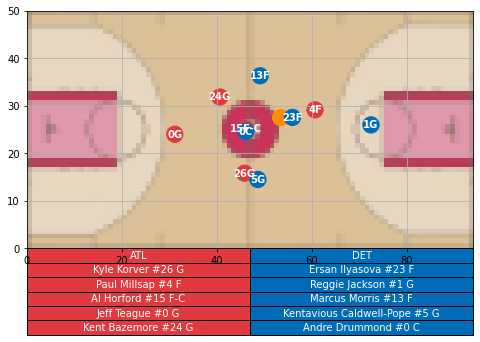

In [5]:
ba = animation.BasketballAnimation(mbd, batch['x'], batch['id_team'], batch['id_player'], None)

In [ ]:
! rm vid.gif

In [91]:
%%time
ba.anim.save('vid.gif', writer='imagemagick')

CPU times: user 26.9 s, sys: 11.4 s, total: 38.3 s
Wall time: 56 s


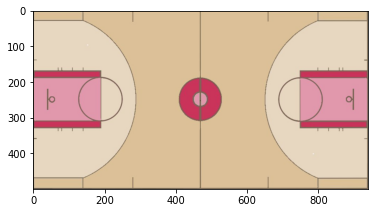

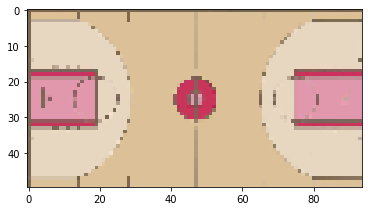

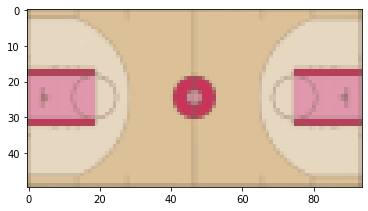

In [6]:
img_court = plt.imread('court.png')
plt.imshow(img_court); plt.show()
a = img_court[::10, ::10]
plt.imshow(a); plt.show()
img_court = cv2.resize(img_court, (94, 50), interpolation=cv2.INTER_AREA)
plt.imshow(img_court); plt.show()

In [7]:
vid = animation.create_video(None, **batch, tqdm=tqdm)

  0%|          | 0/111 [00:00<?, ?it/s]

In [28]:
vids = [vid, vid, vid, vid, vid, vid]
vids = animation.stitch_videos(vids, (3, 2))

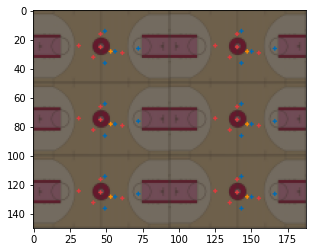

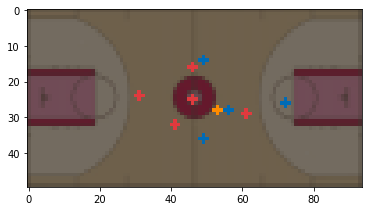

In [29]:
plt.imshow(vids[0].permute(1, 2, 0).numpy())
plt.show()
plt.imshow(vid[0].permute(1, 2, 0).numpy())
plt.show()

In [41]:
import wandb
wandb.init()

wandb: Currently logged in as: akarshkumar0101 (use `wandb login --relogin` to force relogin)


In [42]:
for f in tqdm(['data_processed/'+f for f in os.listdir('data_processed/') if f.endswith('.pth')][:100]):
    batch = torch.load(f)
    vid = animation.create_video(None, **batch, tqdm=tqdm)
    wandb.log({"vids": wandb.Video(vid.numpy(), fps=25)})

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/137 [00:00<?, ?it/s]

  0%|          | 0/494 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/484 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/331 [00:00<?, ?it/s]

  0%|          | 0/173 [00:00<?, ?it/s]

  0%|          | 0/718 [00:00<?, ?it/s]

  0%|          | 0/494 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/257 [00:00<?, ?it/s]

  0%|          | 0/438 [00:00<?, ?it/s]

  0%|          | 0/941 [00:00<?, ?it/s]

  0%|          | 0/652 [00:00<?, ?it/s]

  0%|          | 0/550 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/293 [00:00<?, ?it/s]

  0%|          | 0/487 [00:00<?, ?it/s]

  0%|          | 0/363 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/195 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/419 [00:00<?, ?it/s]

  0%|          | 0/137 [00:00<?, ?it/s]

  0%|          | 0/170 [00:00<?, ?it/s]

  0%|          | 0/205 [00:00<?, ?it/s]

  0%|          | 0/734 [00:00<?, ?it/s]

  0%|          | 0/439 [00:00<?, ?it/s]

  0%|          | 0/695 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/519 [00:00<?, ?it/s]

  0%|          | 0/547 [00:00<?, ?it/s]

  0%|          | 0/385 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/145 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/584 [00:00<?, ?it/s]

  0%|          | 0/353 [00:00<?, ?it/s]

  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/666 [00:00<?, ?it/s]

  0%|          | 0/222 [00:00<?, ?it/s]

  0%|          | 0/427 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/434 [00:00<?, ?it/s]

  0%|          | 0/521 [00:00<?, ?it/s]

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/work/08258/akumar01/maverick2/miniconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3457, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_9241/1210365075.py", line 4, in <module>
    wandb.log({"vids": wandb.Video(vid.numpy(), fps=25)})
  File "/work/08258/akumar01/maverick2/miniconda3/lib/python3.9/site-packages/wandb/sdk/data_types.py", line 1262, in __init__
    self.encode()
  File "/work/08258/akumar01/maverick2/miniconda3/lib/python3.9/site-packages/wandb/sdk/data_types.py", line 1283, in encode
    clip.write_gif(filename, **kwargs)
  File "<decorator-gen-179>", line 2, in write_gif
  File "/work/08258/akumar01/maverick2/miniconda3/lib/python3.9/site-packages/moviepy/decorators.py", line 54, in requires_duration
    return f(clip, *a, **k)
  File "<decorator-gen-178>", line 2, in write_gif
  File "/work/08258/akumar01/maverick2/miniconda3/lib/python3.9/site-packages/movi

TypeError: object of type 'NoneType' has no len()

Exception in thread NetStatThr:
Traceback (most recent call last):
  File "/work/08258/akumar01/maverick2/miniconda3/lib/python3.9/threading.py", line 954, in _bootstrap_inner
    self.run()
  File "/work/08258/akumar01/maverick2/miniconda3/lib/python3.9/threading.py", line 892, in run
    self._target(*self._args, **self._kwargs)
  File "/work/08258/akumar01/maverick2/miniconda3/lib/python3.9/site-packages/wandb/sdk/wandb_run.py", line 149, in check_network_status
    status_response = self._interface.communicate_network_status()
  File "/work/08258/akumar01/maverick2/miniconda3/lib/python3.9/site-packages/wandb/sdk/interface/interface.py", line 125, in communicate_network_status
    resp = self._communicate_network_status(status)
  File "/work/08258/akumar01/maverick2/miniconda3/lib/python3.9/site-packages/wandb/sdk/interface/interface_shared.py", line 397, in _communicate_network_status
    resp = self._communicate(req, local=True)
  File "/work/08258/akumar01/maverick2/miniconda3/l

  0%|          | 0/111 [00:00<?, ?it/s]

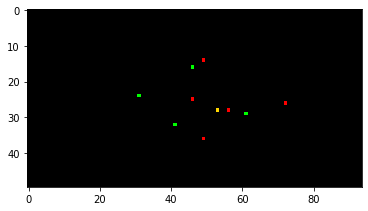

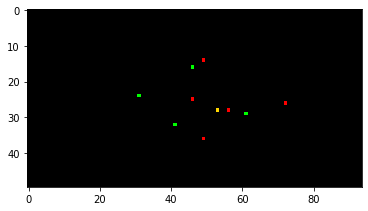

In [ ]:
vid = torch_vid(batch['x'])
plt.imshow(vid[0].permute(1, 2, 0).numpy()); plt.show()
plt.imshow(vid[0].permute(1, 2, 0).numpy()); plt.show()
# plt.imshow(vid[1].permute(1, 2, 0).numpy()); plt.show()
# plt.imshow(vid[2].permute(1, 2, 0).numpy()); plt.show()

In [8]:
import wandb

In [9]:
wandb.init()

wandb: Currently logged in as: akarshkumar0101 (use `wandb login --relogin` to force relogin)


In [13]:
wandb.log({"animation": wandb.Video((vid*255).to(torch.uint8).numpy(), fps=25)})